# Part 1 - Exploratory Data Analysis <br>

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

dfLogin = pd.read_json("logins.json")

In [2]:
dfLogin['count'] = 1
dfLogin.index = dfLogin['login_time']
dfLogin.drop('login_time',axis=1,inplace=True)

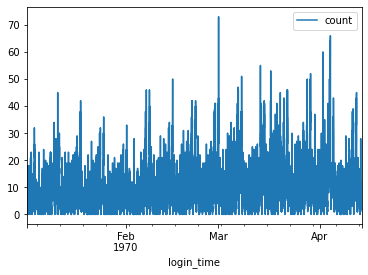

In [3]:
count = dfLogin.resample('15min').sum()
_ = count.plot(kind='line')

<AxesSubplot:xlabel='login_time'>

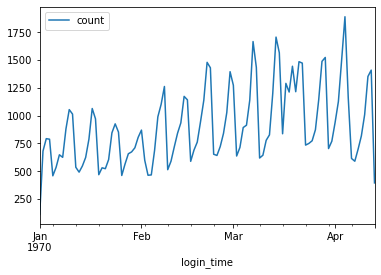

In [4]:
dfDay = dfLogin.resample('1D').sum()
dfDay.plot(kind='line')

# Part 2 - Experiment and Metrics Design <br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
###### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? <br />
- I think that a feature called activity level would be informative to see if the activity levels shift at all for both cities. Location of the driver may be important as well, as it would show if the driver actually managed time in both cities. <br />
###### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: <br />
###### a. how you will implement the experiment <br />
- I believe that the differing circadian rhythms of the two cities will keep the drivers of those cities mainly in their respective city during the week, so while it is the weekend would be the best time to really track the features explained above. So the experiment would go something to the effect of taking a sample of ultimate drivers and calculating how much time they spend in both cities (both before and after implementing the reimbursement policy).<br />
###### b. what statistical test(s) you will conduct to verify the significance of the observation <br />
- Bootstrap Testing <br />
###### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats. <br />
-  If behavior is changed enough after the policy change, then the policy will be statistically significant and can remain. It is important to consider if the revenue generated is greater than the reimbursement costs, there is no purpose in having reimbursements if it ends up losing the company money.

# Part 3 - Predictive Modeling </br>
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.


In [5]:
df = pd.read_json("ultimate_data_challenge.json")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
tripcounts = df['trips_in_first_30_days'].value_counts(normalize=True)*100
print('pecent of drivers retained:', str(np.sum(tripcounts[1:])) + '%')

pecent of drivers retained: 69.22%


In [7]:
print(df.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


three features have null values, below we will fix this.

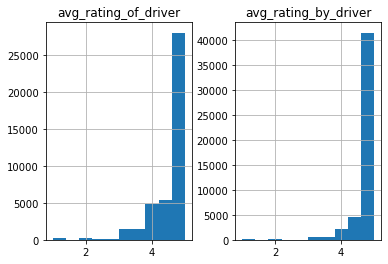

In [8]:
_ = df.hist(column=["avg_rating_of_driver","avg_rating_by_driver"])

In [9]:
#drop missing phone values entirely
df = df.drop(df[df.phone.isna()==True].index,axis=0)
#convert dates
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
#impute rating columns with median values as they aren't a normal distribution
df["avg_rating_of_driver"].fillna(df["avg_rating_of_driver"].median(), inplace = True)
df["avg_rating_by_driver"].fillna(df["avg_rating_of_driver"].median(), inplace = True)
print(df.isnull().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64


In [10]:
current_date = df['last_trip_date'].max()
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [11]:
features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
target = features['active']
features = features.drop(['last_trip_date','signup_date','active'],axis=1)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [13]:
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

### Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.7498236064912811

In [15]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Cross Validated Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.7511335  0.74193548 0.75252016 0.74798387 0.74647177]
Mean Cross Validated Score: 0.7481093584951654


In [17]:
df_importance = pd.DataFrame(zip(list(features.columns),rf.feature_importances_),index=range(features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300900
4,weekday_pct,0.133402
6,avg_rating_by_driver,0.113284
0,trips_in_first_30_days,0.080893
1,avg_rating_of_driver,0.080858
3,surge_pct,0.077846
2,avg_surge,0.066911
8,city_King's Landing,0.046759
11,phone_iPhone,0.019710
10,phone_Android,0.019669


### Logistic Regression

In [18]:
logit = LogisticRegression(solver='lbfgs')
param_grid = {'C':np.arange(0.5,5.1,0.1)}
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))
print(grid.best_estimator_.C)

1.4


In [20]:
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(features.columns),logit_coef.coef_[0]),index=range(features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.083103
1,avg_rating_of_driver,-0.464589
2,avg_surge,2.288528
3,surge_pct,-1.224181
4,weekday_pct,-0.242937
5,avg_dist,0.161726
6,avg_rating_by_driver,-1.327910
7,city_Astapor,-0.760689
8,city_King's Landing,1.130938
9,city_Winterfell,-0.244741


In [21]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

0.7427677845941334


Both Models Perform Similarly, so we will stick with the Random Forest Model - This Model stated that the best features to predict retention would be average distance, weekday percentage, and average rating by driver.<br>
###### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention  <br />
- With all of this in mind, best suggestions for the companies strategy going forward would be to encourage users to use the app on weekends and for long distance trips (via coupons, incentives, etc) as well as to encourage drivers not to artificially inflate customer ratings.

# Data Description </br>
● city: city this user signed up in<br />
● phone: primary device for this user<br />
● signup_date: date of account registration; in the form ‘YYYYMMDD’<br />
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’<br />
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup<br />
● avg_rating_by_driver: the rider’s average rating over all of their trips<br />
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips<br />
● surge_pct: the percent of trips taken with surge multiplier > 1<br />
● avg_surge: The average surge multiplier over all of this user’s trips<br />
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up<br />
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise<br />
● weekday_pct: the percent of the user’s trips occurring during a weekday<br />